## Simulating data for training 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from BinarySearch import binaryServerSearch
%load_ext autoreload
%autoreload 2
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining arrival pattern

24


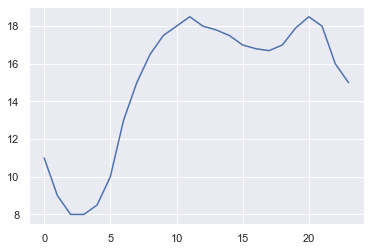

In [2]:
#create arrival schedule for 60min windows
baseSchedule = [11,9,8,8,8.5,10,13,15,16.5,17.5,18,18.5,18,17.8,17.5,17,16.8,16.7,17,17.9,18.5,18,16,15]
print(len(baseSchedule))
plt.plot(baseSchedule)

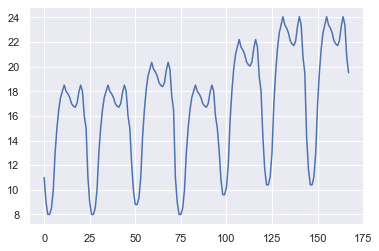

In [3]:
#repeat and add weekly seasonality
ndays = 7
schedule = np.tile(baseSchedule, reps=7)
weeklySeasonality = np.repeat(np.array([1,1,1.1,1,1.2,1.3,1.3]), 24)
schedule = np.array(schedule * weeklySeasonality)
plt.plot(schedule)

Text(0.5, 1.0, 'Final arrival schedule for 1 week')

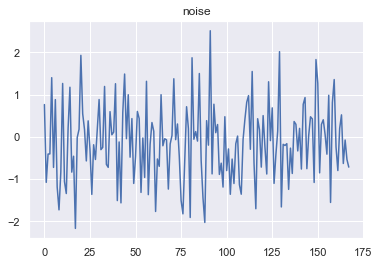

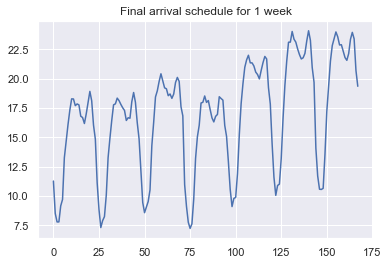

In [4]:
#add some noise
noise = np.random.normal(loc = 0,scale=1,size=schedule.shape[0])
#scale the noise
scale = 4 #increase this to increase the variance of the noise
noiseScaled = noise/schedule*scale#noise will be heteroskedastic proportional to the magnitude of the arrivals
plt.title("noise")
plt.plot(noise)
plt.figure()
scheduleNoised = schedule + noiseScaled
plt.plot(scheduleNoised)
plt.title("Final arrival schedule for 1 week")

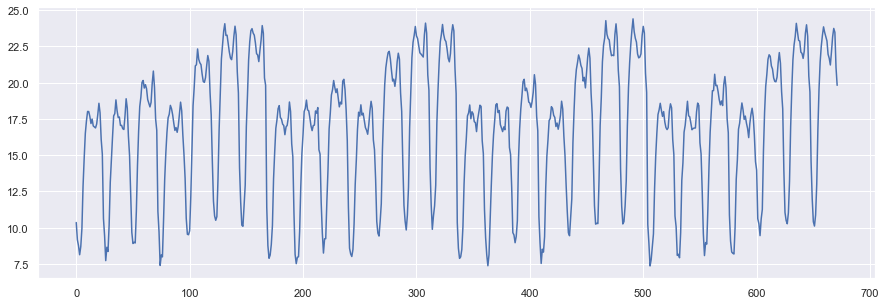

In [5]:
#Create longer schedule: 4 weeks
nWeeks = 4
scale = 4
noise = np.random.normal(loc = 0,scale=1,size=schedule.shape[0]*nWeeks)
fullSchedule = np.tile(schedule, nWeeks)
fullSchedule = fullSchedule + noise/fullSchedule * scale
plt.figure(figsize=(15,5))
plt.plot(fullSchedule)

### Optimal Number Of Servers for each arrival rate
We want to know for each arrival rate, what is the optimal number of servers for the given settings. We use binary search to determine this value

In [13]:
#define simulation settings
samplingInterval = 0.05
processCost = 1
cancelCost = -10
serverCost = -300
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)]


#define search settings
arrivalsPerSecondList = np.arange(7.5,25.5,0.5)
simDuration = 1*60*60 #duration of each simulation
print(arrivalsPerSecondList) #these are the values we are searching for the optimumn for
searchSpace = [10,70]

[ 7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25. ]


In [7]:

optResults = {k: None for k in arrivalsPerSecondList}
for arrivalsPerSecond in tqdm(arrivalsPerSecondList):
    arrivalRate = arrivalsPerSecond * samplingInterval #binaryServerSearch asks for arrival rate instead of arrivalsPerSecond, so converting
    optNServers = binaryServerSearch(arrivalRate=arrivalRate, searchSpace=searchSpace, processCost = processCost, cancelCost = cancelCost, serverCost = serverCost, requestTypes=requestTypes, simDuration=simDuration)
    optResults[arrivalsPerSecond] = optNServers
print(optResults)
optResultsDf = pd.DataFrame(index=optResults.keys(), data=optResults.values(), columns = ['Optimal number of servers'])
optResultsDf.to_csv('./data/optServers.csv')

  0%|          | 0/18 [00:00<?, ?it/s]

{7.5: 14, 8.0: 14, 8.5: 15, 9.0: 20, 9.5: 19, 10.0: 19, 10.5: 19, 11.0: 20, 11.5: 20, 12.0: 28, 12.5: 28, 13.0: 28, 13.5: 28, 14.0: 28, 14.5: 28, 15.0: 28, 15.5: 28, 16.0: 29, 16.5: 29, 17.0: 30, 17.5: 31, 18.0: 32, 18.5: 33, 19.0: 34, 19.5: 36, 20.0: 36, 20.5: 36, 21.0: 36, 21.5: 36, 22.0: 36, 22.5: 36, 23.0: 36, 23.5: 36, 24.0: 36, 24.5: 36, 25.0: 36}


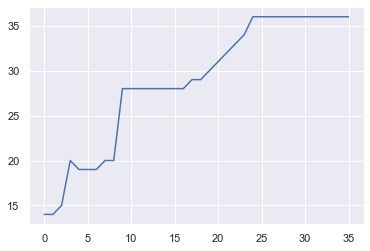

In [14]:
optResultsDf = pd.read_csv('./data/optServers.csv')['Optimal number of servers']
optResultsDf.plot() 
optResultsDf = optResultsDf.to_dict()
optResults = {k:v for k,v in zip(arrivalsPerSecondList, optResultsDf.values())}
print(optResults)

### Simulating the system
Now that we now the optimum number of servers, we simulate the system under the optimal number of servers. First we implement a custom loadbalancer that changes the number of servers dynamically

In [23]:
from LoadBalancer import LoadBalancer
from Environment import Environment
from Server import Server

class ServerScheduledLoadBalancer(LoadBalancer):
    """
    Loadbalancer assigning to servers random
    """
    def __init__(self, nServers, environment: Environment, nServersList: list):
        super().__init__(nServers=nServersList[0],environment=environment)
        self.nServersList = nServersList #list of nServers
        self.currentPeriod = 0
        self.nServers = nServersList[0]
        self.nPeriods = len(nServersList)
    
    def _setNumberOfServers(self, newNumber):
        self.environment.logData("numberOfServers", self.nServers) #log before

        if newNumber > self.nServers:
            diff = newNumber - self.nServers
            newServers = [Server(environment=self.environment, id=i) for i in range(diff)]
            self.serverList = self.serverList + newServers
            self.currentServer = newNumber - 1
        elif newNumber < self.nServers:
            self.serverList = self.serverList[:newNumber]
        
        self.nServers = newNumber
        #print(newNumber)
        self.environment.logData("numberOfServers", self.nServers) # log after

    def onPeriodEnd(self):
        """
        go to next number of servers
        """
        self.currentPeriod +=1
        if self.currentPeriod >= self.nPeriods:
            self.currentPeriod = 0
        print(self.currentPeriod, self.nPeriods, self.nServersList[self.currentPeriod], self.nServers, end='\r')            
        self._setNumberOfServers(self.nServersList[self.currentPeriod])

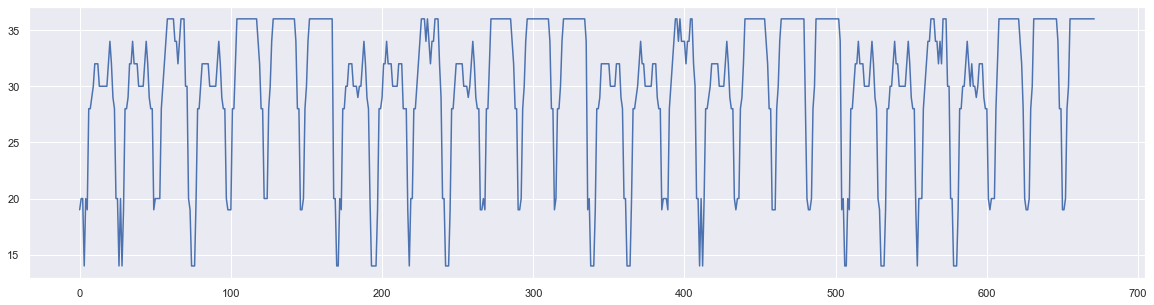

In [24]:
#determine for each period in the schedule which amount of servers should be used
numberOfServersSchedule = []
allKeys = list(optResults.keys())
for arrivalsPerSecond in fullSchedule:
    arrivalsPerSecondRounded = round(arrivalsPerSecond*1)/1

    if arrivalsPerSecondRounded not in optResults.keys():
        arrivalsPerSecondRounded = min(allKeys) if arrivalsPerSecond < min(allKeys) else max(allKeys) 

    optNumberOfServers = optResults[arrivalsPerSecondRounded]
    numberOfServersSchedule.append(optNumberOfServers)
#print(numberOfServersSchedule)
plt.figure(figsize=(20,5))
plt.plot(numberOfServersSchedule)

In [25]:
from Source import ArrivalSchedule, Source

#define simulation settings
samplingInterval = 0.05
processCost = 1
cancelCost = -10
serverCost = -300
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)]

#define the system for 4 week simulation
stopTime = 1*7*24*60*60
#stopTime = 5*60*60

periodLength = 60*60
env = Environment(stopTime=stopTime)
loadBalancer = ServerScheduledLoadBalancer(nServers = 10, environment=env, nServersList=numberOfServersSchedule)
source = Source(arrivalsPerSecond=10, requestTypes = requestTypes, loadBalancer = loadBalancer,environment = env)
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=fullSchedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

In [28]:
import pickle
with open('./data/1weekSimLog', 'wb') as file:
    pickle.dump(env.log, file)

with open('./data/1weekSimLogTime', 'wb') as file:
    pickle.dump(env.logTime, file)

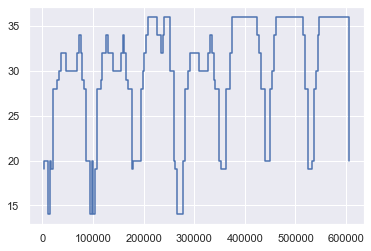

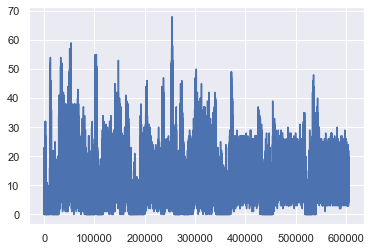

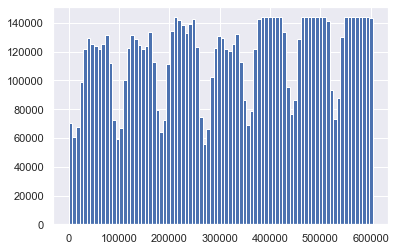

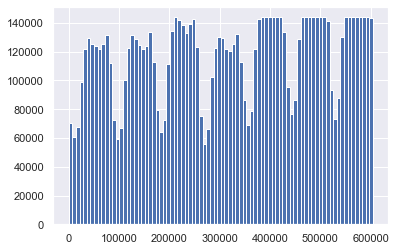

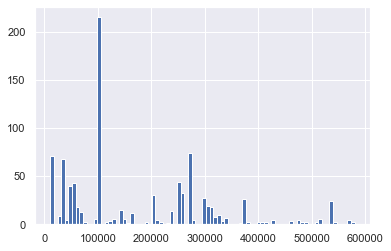

In [36]:
#checking results
plt.plot(env.logTime["numberOfServers"], env.log["numberOfServers"])
plt.figure()
plt.plot(env.logTime["totalInQueue"], env.log["totalInQueue"])
plt.figure()
plt.hist(env.logTime["arrivalEvent"], bins = 7*12);
plt.figure()
plt.hist(env.logTime["requestProcessed"], bins = 7*12);
plt.figure()
plt.hist(env.logTime["requestCancelled"], bins = 7*12);

In [31]:
env.log.keys()

dict_keys(['sampleEvent', 'arrivalEvent', 'requestStartWaiting', 'requestType', 'requestWaitingTime', 'totalInQueue', 'requestProcessed', 'totalTimeInSystem', 'queueSize_1', 'queueSize_4', 'queueSize_5', 'queueSize_6', 'queueSize_7', 'queueSize_8', 'queueSize_9', 'queueSize_12', 'queueSize_13', 'queueSize_14', 'queueSize_16', 'queueSize_17', 'queueSize_18', 'queueSize_10', 'queueSize_15', 'queueSize_0', 'queueSize_2', 'queueSize_3', 'queueSize_11', 'numberOfServers', 'requestCancelled'])

In [72]:
#generate the series
dfs = []
for k in env.log.keys():
    if 'queueSize' in k: continue
    df = pd.DataFrame(index = env.logTime[k], data=env.log[k], columns=[k])
    df['periodIndex'] = (df.index/60/60).astype(int)
    if k in ['totalTimeInSystem', 'numberOfServers','totalInQueue','requestWaitingTime','requestType']:
        df = df.groupby(by='periodIndex').mean()
    else:
        df = df.groupby(by='periodIndex').sum()
    dfs.append(df)

finalDf = pd.concat(dfs, axis=1)
finalDf.head()

ValueError: Length of values (168) does not match length of index (169)

In [74]:
finalDf['nextPeriodOptimalServers'] = numberOfServersSchedule[1:7*24+2]


In [76]:
finalDf.to_csv('./data/simulatedData_1')

In [75]:
finalDf

,sampleEvent,arrivalEvent,requestStartWaiting,requestType,requestWaitingTime,totalInQueue,requestProcessed,totalTimeInSystem,numberOfServers,requestCancelled,nextPeriodOptimalServers
periodIndex,,,,,,,,,,,
0,71999.0,37502.0,37502.0,0.664285,0.747290,8.324623,37475.0,2.412016,NaN,NaN,20
1,72000.0,32883.0,32883.0,0.671654,0.093902,1.072956,32892.0,1.766014,19.5,NaN,20
2,72001.0,31363.0,31363.0,0.666358,0.054013,0.626821,31370.0,1.718995,20.0,NaN,14
3,72000.0,29385.0,29385.0,0.667654,2.076455,17.701480,29352.0,3.741790,17.0,71.0,20
4,72000.0,31369.0,31369.0,0.667538,0.071910,0.779209,31392.0,1.741993,17.0,NaN,19
...,...,...,...,...,...,...,...,...,...,...,...
164,72000.0,72000.0,72000.0,0.665750,0.668992,13.750556,72005.0,2.335741,36.0,NaN,36
165,72000.0,72000.0,72000.0,0.664736,0.665507,13.678944,71996.0,2.329701,36.0,NaN,36
166,72000.0,72000.0,72000.0,0.666833,0.689443,14.160083,72000.0,2.357273,36.0,NaN,36
